In [8]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import interp1d

p0 = 101325
T0 = 300 # paper
phi = 0.7 # equivalence ratio
alpha = 0.8 # paper>0.6~0.8
width = 0.02 # 2cm
loglevel = 0

xh2 = alpha / (1 - alpha) * 1
fuel = {'CH4': 1, 'H2': xh2}
oxidizer = {'O2': 1, 'N2': 3.76}

gas = ct.Solution('gri30.yaml')
gas.TP = T0, p0
gas.set_equivalence_ratio(phi, fuel, oxidizer)

In [9]:
flame = ct.FreeFlame(gas, width=width)
flame.solve(loglevel, auto=True)
flame_speed = flame.velocity[0] #Sl0
print(f'Flame speed: {flame_speed:.5f} m/s')

Flame speed: 0.61069 m/s


In [10]:
def get_adiabatic_temperature_from_flame(flame): # lamninar unstretched flame
    Tad = flame.T[-1]  # final status of the flame
    return Tad

Tad = get_adiabatic_temperature_from_flame(flame) # laminar unstretched configuration
print(f'Adiabatic temperature (Tad) from FreeFlame: {Tad:.2f} K')
Xflame = flame.X[:,-1]

#thermal diffusivity
cp = flame.cp_mass[0]
density = flame.density_mass[0]    
lambda_ = flame.thermal_conductivity[0]
thermal_diffusivity = lambda_ / (density * cp)

Adiabatic temperature (Tad) from FreeFlame: 1890.95 K


In [11]:
def calculate_consumption_speed(flame_cf, gas, fuel_species):
    rho_u = flame_cf.density[0]
    total_fuel_mass_fraction = sum(flame_cf.Y[gas.species_index(fuel), 0] for fuel in fuel_species)

    integral_numerator = 0
    for fuel in fuel_species:
        i_fuel = gas.species_index(fuel)
        nk = flame_cf.Y[i_fuel, 0] / total_fuel_mass_fraction
        integral = scipy.integrate.simpson(gas.molecular_weights[i_fuel] * flame_cf.net_production_rates[i_fuel], x=flame_cf.grid)
        integral_numerator += nk * integral

    mass_fraction_diff = sum(flame_cf.Y[gas.species_index(fuel), -1] - flame_cf.Y[gas.species_index(fuel), 0] for fuel in fuel_species)
    S_cF = integral_numerator / (rho_u * mass_fraction_diff)
    return S_cF

In [12]:
mdot_values = np.logspace(-2, 2, 50)  # From 0.01 to 100 with 50 points
Ka_values = []
ScF_values = []

# Loop through mdot values
for mdot in mdot_values:
    # Initialize gas object in each iteration to avoid carrying over previous states
    gas = ct.Solution('gri30.yaml')
    gas.TP = T0, p0
    gas.set_equivalence_ratio(phi, fuel, oxidizer)
    
    flame_cf = ct.CounterflowPremixedFlame(gas=gas, width=width)
    flame_cf.transport_model = 'multicomponent'
    flame_cf.energy_enabled = True
    flame.soret_enabled = True
    flame_cf.set_refine_criteria(ratio=3, slope=0.1, curve=0.2, prune=0.02)
    flame_cf.reactants.mdot = mdot
    flame_cf.products.mdot = mdot
    flame_cf.products.T = Tad  # no heat loss(beta=1)
    flame_cf.products.X = Xflame
    flame_cf.set_initial_guess(equilibrate=False)
    
    flame_cf.solve(loglevel, auto=True)

    # Update temperature for current mdot
    Tp = 1000 #revise
    
    # Calculate the maximum gradient |du/dx|
    grad_u = np.gradient(flame_cf.velocity, flame_cf.grid) 
    max_grad_idx = np.argmax(np.abs(grad_u))  # find max |du/dx| index
    max_grad_value = np.abs(grad_u[max_grad_idx])
    
    # Calculate strain rate (Ka)
    Ka = (thermal_diffusivity/flame_speed) / flame_speed * max_grad_value
    Ka_values.append(Ka)
    
    ScF = calculate_consumption_speed(flame_cf, gas, ['CH4', 'H2'])
    ScF_values.append(ScF)
    print(ScF)

0.015194922084368416
0.01730124943082125
0.019830701725976285
0.022808253031185423
0.026383015517780523
0.030633202127165027
0.03567141712841763
0.04162053820650389
0.04860325073339445
0.05677047084292306
0.06610967171089602
0.07757736900209003
0.09007392723075967
0.10440793904794282
0.12068380995526516
0.14014543858639505
0.16123601848474675
0.18506856053851697
0.2114233369944963
0.24116061917819082
0.2737873578958893
0.3063689719207522
0.31614235942227187
0.31741040237155066
0.32041243219394366
0.3221955860220907
0.3245556794861065
0.3270662193139636
0.3305172794840965
0.333909321130544
0.3364222055970562
0.3397410429672664
0.342935893291058
0.3450587929597128
0.34773795996891727
0.3493127584491522
0.350569978494475
0.3496136814201495
0.3481203615524018
0.34491604975572226
0.34051965277294144
0.3351867590505719
0.3301954895508293
0.323714219725801
0.317251539366628
0.3090475087970445
0.2989486204989817
0.28725917721716504
0.27324404235065675
0.25537838520770917


In [13]:
y_values = []
for i in ScF_values:
    temp = i / flame_speed
    y_values.append(temp)

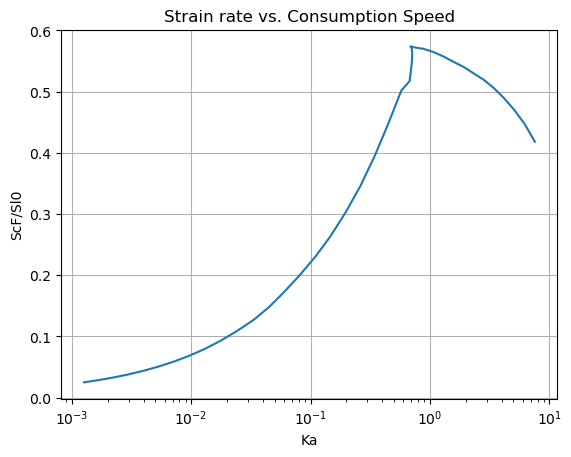

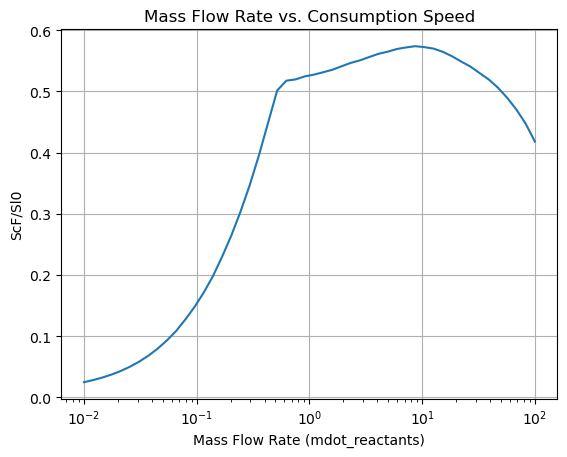

In [14]:
plt.plot(Ka_values, y_values)
plt.xscale('log')
plt.xlabel('Ka')
plt.ylabel('ScF/Sl0')
plt.title('Strain rate vs. Consumption Speed')
plt.grid(True)
plt.show()

plt.plot(mdot_values, y_values)
plt.xscale('log')
plt.xlabel('Mass Flow Rate (mdot_reactants)')
plt.ylabel('ScF/Sl0')
plt.title('Mass Flow Rate vs. Consumption Speed')
plt.grid(True)
plt.show()